In [2]:
# Standard libraries
import csv
import json
import os
import re
import shutil

# Data processing and analysis
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
import difflib 

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing and OCR
from PIL import Image, ImageDraw
import cv2
import pytesseract

# Transformers and huggingface_hub
from huggingface_hub import hf_hub_download
from transformers import DetrFeatureExtractor, TableTransformerForObjectDetection

# PyTorch
import torch


1. Create the data counting rows and columns for evaluation
- there is some change from the main code from table_transformer.ibynb

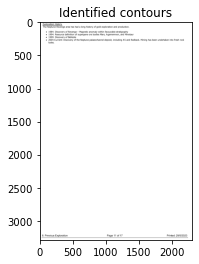

No Table Detected.


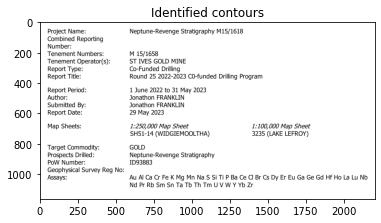

No Table Detected.


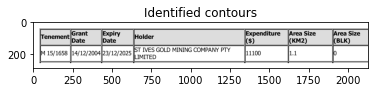

Table Extracted!


In [7]:
def find_subdirs_with_name(path, keyword):
    """Return all subdirectories containing the given keyword."""
    return [os.path.join(root, directory) for root, dirs, files in os.walk(path) for directory in dirs if keyword in directory]

def find_image_files_in_dir(path):
    """Return all image files in the directory."""
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff']
    return [os.path.join(root, file) for root, dirs, files in os.walk(path) for file in files if any(file.lower().endswith(ext) for ext in image_extensions)]


def process_image(image_path):
    image = cv2.imread(image_path, 0)
    
    img_bin = 255 - image
    _, img_bin_otsu = cv2.threshold(img_bin, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Vertical Line extraction
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, np.array(img_bin_otsu).shape[1]//150))
    eroded_image = cv2.erode(img_bin_otsu, vertical_kernel, iterations=5)
    vertical_lines = cv2.dilate(eroded_image, vertical_kernel, iterations=5)
    
    # Horizontal Line extraction
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img_bin_otsu).shape[1]//150, 1))
    image_2 = cv2.erode(img_bin_otsu, hor_kernel, iterations=5)
    horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=5)

    # Combining
    vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)
    _, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    b_image = cv2.bitwise_not(cv2.bitwise_xor(image, vertical_horizontal_lines))
    return b_image, vertical_horizontal_lines


def extract_bounding_boxes(b_image, vertical_horizontal_lines):
    contours, _ = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    boundingBoxes = [cv2.boundingRect(contour) for contour in contours]
    (contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes), key=lambda x: x[1][1]))

    boxes = []
    image_copy = b_image.copy()  # Initialize image_copy here
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w < 1000 and h < 500:
            cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0, 0, 255), 1)
            boxes.append([x, y, w, h])
    plt.imshow(image_copy, cmap='gray')
    plt.title("Identified contours")
    plt.show()
    return boxes



def extract_text_from_boxes(b_image, boxes):
    rows = []
    columns = []
    heights = [box[3] for box in boxes]  # Extracting the heights of all boxes
    mean_height = np.mean(heights)

    # Initialize columns list with the first box and set the previous box to the first box
    columns.append(boxes[0])
    previous_box = boxes[0]

    for i in range(1, len(boxes)):
        if boxes[i][1] <= previous_box[1] + mean_height / 2:
            columns.append(boxes[i])
            previous_box = boxes[i]
            if i == len(boxes) - 1:
                rows.append(columns)
        else:
            rows.append(columns)
            columns = []
            previous_box = boxes[i]
            columns.append(boxes[i])

    # Determine the total number of cells in the row with the maximum cells
    total_cells = max([len(r) for r in rows])

    # Find the center of each box in the first row
    centers = [int(rows[0][j][0] + rows[0][j][2] / 2) for j in range(len(rows[0]))]
    centers = np.array(centers)
    centers.sort()

    # Organize boxes by their closest center position
    boxes_list = []
    for i in range(len(rows)):
        l = [[] for _ in range(total_cells)]
        for j in range(len(rows[i])):
            # Find the closest center for the current box
            diff = abs(centers - (rows[i][j][0] + rows[i][j][2] / 4))
            minimum = min(diff)
            index = list(diff).index(minimum)
            l[index].append(rows[i][j])
        boxes_list.append(l)

    # Extracting text from cells in the image
    dataframe_final = []
    for i in range(len(boxes_list)):
        for j in range(len(boxes_list[i])):
            s = ''
            if len(boxes_list[i][j]) == 0:
                dataframe_final.append(' ')
            else:
                for k in range(len(boxes_list[i][j])):
                    x, y, w, h = boxes_list[i][j][k]
                    roi = b_image[y:y+h, x:x+w]
                    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                    border = cv2.copyMakeBorder(roi, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=[255, 255])
                    resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                    dilation = cv2.dilate(resizing, kernel, iterations=1)
                    erosion = cv2.erode(dilation, kernel, iterations=2)
                    out = pytesseract.image_to_string(erosion).strip()
                    s += " " + out
                dataframe_final.append(s)

    arr = np.array(dataframe_final)
    dataframe = pd.DataFrame(arr.reshape(len(rows), total_cells))

    return dataframe


# Modify the existing code
def ocr_image_to_text(image_path, extracted_dir, counter):
    b_image, vertical_horizontal_lines = process_image(image_path)
    boxes = extract_bounding_boxes(b_image, vertical_horizontal_lines)

    if len(boxes) <= 1:
        print("No Table Detected.")
        return counter  # Return the current counter value
    else:
        print('Table Extracted!')
        dataframe = extract_text_from_boxes(b_image, boxes)

        # Extract file and page numbers from the image file name
        file_name = os.path.basename(image_path)
        parts = file_name.split("_")
        file_number = parts[0]
        page_number = parts[1]
        table_number = parts[3][0]
        
        # Append the number of rows, columns, file number, and page number to the global variables
        total_rows.append(dataframe.shape[0])
        total_columns.append(dataframe.shape[1])
        file_numbers.append(file_number)
        page_numbers.append(page_number)
        table_numbers.append(table_number)

        # Modify the output file path to include the extracted file name
        output_dir = os.path.dirname(extracted_dir)
        csv_output_path = os.path.join(output_dir, f"{file_number}_{page_number}_table_{table_number}.csv")

        dataframe.to_csv(csv_output_path, index=False, header=False)

        counter += 1  # Increment the counter
    return counter  # Return the updated counter value


def process_images_in_extracted_dirs(main_wd, output_dir):
    global processed_tables_counter
    global total_rows, total_columns, file_numbers, page_numbers, table_numbers

    cropped_dirs = find_subdirs_with_name(main_wd, "Cropped")
    processed_tables_counter = 0
    total_rows = []
    total_columns = []
    file_numbers = []
    page_numbers = []
    table_numbers = []

    for extracted_dir in cropped_dirs:
        for image_path in find_image_files_in_dir(extracted_dir):
            processed_tables_counter = ocr_image_to_text(image_path, extracted_dir, processed_tables_counter)

    # Ensure all arrays have the same length
    max_length = max(len(file_numbers), len(page_numbers), len(table_numbers), len(total_rows), len(total_columns))


    # Fill in missing values with placeholders ('N/A' or 0)
    file_numbers += ['N/A'] * (max_length - len(file_numbers))
    page_numbers += ['N/A'] * (max_length - len(page_numbers))
    table_numbers += ['N/A'] * (max_length - len(table_numbers))
    total_rows += [0] * (max_length - len(total_rows))
    total_columns += [0] * (max_length - len(total_columns))

    # Create the DataFrame
    summary_df = pd.DataFrame({
        'file_number': file_numbers,
        'page_number': page_numbers,
        'table_number': table_numbers,
        'num_row (model detected)': total_rows,
        'num_col (model detected)': total_columns
    })

    # Save the summary to 'summary.csv'
    summary_csv_path = os.path.join(output_dir, "summary.csv")
    summary_df.to_csv(summary_csv_path, index=False)


 # Introduce a global counter
 # Add these global variables to store the total rows, total columns, and file and page numbers to label test data set
total_rows = []
total_columns = []
file_numbers = []
page_numbers = []
table_numbers = []

# working directory which has each image file converted from pdf files
main_wd = r'C:/Users/user/Documents/capstone/Test Dataset__2/135347'
output_directory = os.path.dirname(main_wd)
process_images_in_extracted_dirs(main_wd, output_directory)

2. Evaluate accuracy of table extraction

In [4]:
# Load the csv file containing model and human counts
summary_test_df = pd.read_csv('C:/Users/user/Documents/capstone/Labeled Data (Table Extraction).csv')

# Calculate the accuracy for rows and columns separately
row_accuracy = (1 - abs(summary_test_df['num_row (human)'] - summary_test_df['num_row (model)']) / summary_test_df['num_row (human)']) * 100
col_accuracy = (1 - abs(summary_test_df['num_col (human)'] - summary_test_df['num_col (model)']) / summary_test_df['num_col (human)']) * 100

# Calculate overall accuracy as the average of row and column accuracies
overall_accuracy = (row_accuracy + col_accuracy) / 2

# Create a new DataFrame to store accuracy values
accuracy_df = pd.DataFrame({
    'file_number': summary_test_df['file_number'],
    'page_number': summary_test_df['page_number'],
    'row_accuracy': row_accuracy,
    'col_accuracy': col_accuracy,
    'overall_accuracy': overall_accuracy
})

2-(1) Visualise the accuracy of table extraction

Overall Accuracy: 83.47%
col_accuracy: 73.15%
row_accuracy: 93.79%


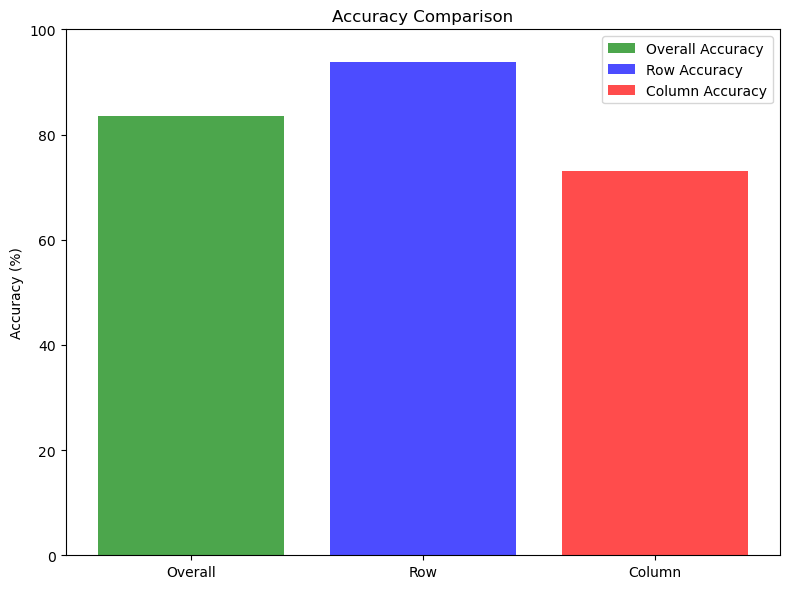

In [5]:
# Calculate the overall accuracy as the mean of all page accuracies
overall_accuracy = accuracy_df['overall_accuracy'].mean()
col_accuracy = accuracy_df['col_accuracy'].mean()
row_accuracy = accuracy_df['row_accuracy'].mean()
print(f'Overall Accuracy: {overall_accuracy:.2f}%')
print(f'col_accuracy: {col_accuracy:.2f}%')
print(f'row_accuracy: {row_accuracy:.2f}%')

# Calculate the overall accuracy as the mean of all page accuracies
overall_accuracy = accuracy_df['overall_accuracy'].mean()

# Create a bar chart for overall, row, and column accuracy
plt.figure(figsize=(8, 6))

# Overall Accuracy
plt.bar('Overall', overall_accuracy, color='g', alpha=0.7, label='Overall Accuracy')
# Row Accuracy
plt.bar('Row', accuracy_df['row_accuracy'].mean(), color='b', alpha=0.7, label='Row Accuracy')
# Column Accuracy
plt.bar('Column', accuracy_df['col_accuracy'].mean(), color='r', alpha=0.7, label='Column Accuracy')

plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

2-(2) Visualise the number of columns and rows match in the data

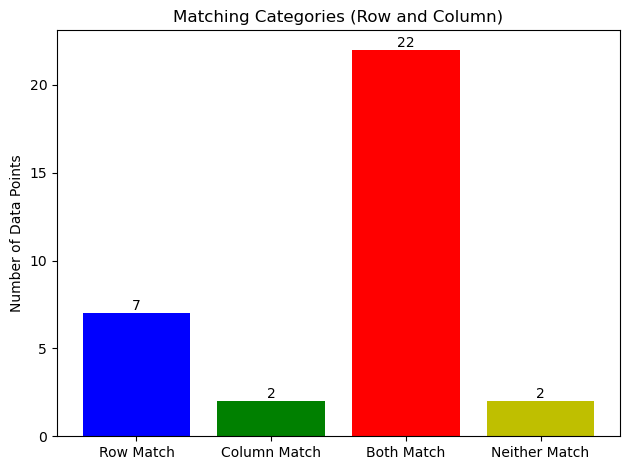

In [6]:
# Categorize the data based on row and column matching
row_match = (summary_test_df['num_row (model)'] == summary_test_df['num_row (human)']) & (summary_test_df['num_col (model)'] != summary_test_df['num_col (human)'])
col_match = (summary_test_df['num_row (model)'] != summary_test_df['num_row (human)']) & (summary_test_df['num_col (model)'] == summary_test_df['num_col (human)'])
both_match = (summary_test_df['num_row (model)'] == summary_test_df['num_row (human)']) & (summary_test_df['num_col (model)'] == summary_test_df['num_col (human)'])
neither_match = (summary_test_df['num_row (model)'] != summary_test_df['num_row (human)']) & (summary_test_df['num_col (model)'] != summary_test_df['num_col (human)'])

# Calculate the number of data points in each category
row_match_count = row_match.sum()
col_match_count = col_match.sum()
both_match_count = both_match.sum()
neither_match_count = neither_match.sum()

# Create a bar chart to visualize the counts
categories = ['Row Match', 'Column Match', 'Both Match', 'Neither Match']
counts = [row_match_count, col_match_count, both_match_count, neither_match_count]

plt.bar(categories, counts, color=['b', 'g', 'r', 'y'])
plt.ylabel('Number of Data Points')
plt.title('Matching Categories (Row and Column)')
plt.tight_layout()

for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Show the plot
plt.show()


3. Evaluate text extraction

In [7]:
# Define the main directory path to search for CSV files(ground truth and files created by model) to evaluate
main_path = "C:/Users/user/Documents/capstone/extract text test_2/"

# Initialize lists to store results
file_names = []
average_accuracies = []

# Function to calculate average accuracy for a given CSV file pair
def calculate_average_accuracy(ground_truth_csv_path, test_csv_path):
    ground_truth_df = pd.read_csv(ground_truth_csv_path, header=None)
    test_df = pd.read_csv(test_csv_path, header=None)

    num_rows_ground_truth, num_columns_ground_truth = ground_truth_df.shape
    num_rows_test, num_columns_test = test_df.shape

    num_rows = max(num_rows_ground_truth, num_rows_test)
    num_columns = max(num_columns_ground_truth, num_columns_test)

    total_similarity = 0
    non_empty_cells = 0

    for i in range(num_rows):
        for j in range(num_columns):
            if i < num_rows_ground_truth and j < num_columns_ground_truth:
                cell_text_ground_truth = ground_truth_df.iat[i, j]
                cell_text_ground_truth = str(cell_text_ground_truth)
            else:
                cell_text_ground_truth = ""

            if i < num_rows_test and j < num_columns_test:
                cell_text_test = test_df.iat[i, j]
                cell_text_test = str(cell_text_test)
            else:
                cell_text_test = ""

            similarity = difflib.SequenceMatcher(None, cell_text_ground_truth, cell_text_test).ratio()

            if cell_text_ground_truth != "" or cell_text_test != "":
                total_similarity += similarity
                non_empty_cells += 1

    if non_empty_cells == 0:
        return 0
    else:
        return total_similarity / non_empty_cells

# Create an empty list to store individual accuracies for each file
individual_accuracies = []

# Create a list to store all file names
all_file_names = []

# Walk through subdirectories in the main path
for root, dirs, files in os.walk(main_path):
    # Filter CSV files
    csv_files = [f for f in files if f.endswith(".csv")]
    csv_files.sort()

    # Create a dictionary to group CSV files based on the split elements
    file_groups = {}

    for csv_file in csv_files:
        parts = csv_file.split("_")
        if len(parts) > 3:  # Ensure at least four parts are available
            key = (parts[0], parts[1], parts[3])  # Use the first, second, and fourth parts
            if key not in file_groups:
                file_groups[key] = []
            file_groups[key].append(csv_file)

    # Check if there are at least two CSV files in each group to compare
    for group_files in file_groups.values():
        if len(group_files) >= 2:
            # Iterate through the CSV files within each group
            for i in range(len(group_files) - 1):
                for j in range(i + 1, len(group_files)):
                    ground_truth_csv_path = os.path.join(root, group_files[i])
                    test_csv_path = os.path.join(root, group_files[j])

                    average_accuracy = calculate_average_accuracy(ground_truth_csv_path, test_csv_path)

                    parts=group_files[0].split("_")

                    # Append file names and average accuracies to lists
                    file_names.append((parts[0], parts[1], parts[3][0]))
                    average_accuracies.append(average_accuracy)

# Calculate the average of all average accuracies
overall_average_accuracy = sum(average_accuracies) / len(average_accuracies)

# Append the overall average accuracy to the average_accuracies list
average_accuracies.append(overall_average_accuracy)

# Append "Overall Average" to the file_names list (or any identifier you prefer)
file_names.append("   ")

# Create a DataFrame to store the results
result_df = pd.DataFrame({
    "A file number": [item[0] for item in file_names],
    "Page number": [item[1] for item in file_names],
    "Table number": [item[2] for item in file_names],
    "Average Accuracy": average_accuracies
})

result_df

,A file number,Page number,Table number,Average Accuracy
0,108156,14,0,0.715615
1,108156,16,0,0.020084
2,108156,7,0,0.174124
3,108156,8,0,0.170646
4,112050,12,0,0.008404
5,112050,13,0,0.503690
6,112050,7,0,0.770359
7,112461,7,0,0.790668
8,112540,7,0,0.127778
9,112540,7,1,0.929738


appendix 1. Compare text extraction of each cell between each csv file

In [10]:
# Import the CSV files including ground truth and test data
ground_truth_csv_file_path = "C:/Users/user/Documents/capstone/extract text test_2/108156_14_ans_0.csv"  # Replace with the path to your ground truth CSV file
test_csv_file_path = "C:/Users/user/Documents/capstone/extract text test_2/108156_14_table_0.csv"  # Replace with the path to your test data CSV file

# Read the CSV files into dataframes without specifying header
ground_truth_df = pd.read_csv(ground_truth_csv_file_path, header=None)
test_df = pd.read_csv(test_csv_file_path, header=None)

# Determine the number of rows and columns in the two dataframes
num_rows_ground_truth, num_columns_ground_truth = ground_truth_df.shape
num_rows_test, num_columns_test = test_df.shape

# Choose the number of rows and columns for comparison based on the larger of the two dataframes
num_rows = max(num_rows_ground_truth, num_rows_test)
num_columns = max(num_columns_ground_truth, num_columns_test)

# Create a dataframe to store the results
text_similarity_df = pd.DataFrame(columns=["Row", "Column", "Similarity"])

# Initialize variables to calculate total similarity and count of non-empty cells
total_similarity = 0
non_empty_cells = 0

# Compare each cell
for i in range(num_rows):
    for j in range(num_columns):
        # Extract cell text from both dataframes
        if i < num_rows_ground_truth and j < num_columns_ground_truth:
            cell_text_ground_truth = ground_truth_df.iat[i, j]
            cell_text_ground_truth = str(cell_text_ground_truth)
        else:
            cell_text_ground_truth = ""

        if i < num_rows_test and j < num_columns_test:
            cell_text_test = test_df.iat[i, j]
            cell_text_test = str(cell_text_test)
        else:
            cell_text_test = ""

        # Compare text and calculate similarity
        similarity = difflib.SequenceMatcher(None, cell_text_ground_truth, cell_text_test).ratio()

        # Add the result to the result dataframe
        text_similarity_df = text_similarity_df.append({"Row": i+1, "Column": j+1, "Similarity": similarity}, ignore_index=True)

        # Update total similarity and count of non-empty cells
        if cell_text_ground_truth != "" or cell_text_test != "":
            total_similarity += similarity
            non_empty_cells += 1

# Calculate the average similarity (accuracy)
average_similarity = total_similarity / non_empty_cells

# Add the average similarity to the result dataframe
text_similarity_df = text_similarity_df.append({"Row": "Average", "Column": "Similarity", "Similarity": average_similarity}, ignore_index=True)

text_similarity_df


C:\Users\user\AppData\Local\Temp\ipykernel_26296\1690335457.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  text_similarity_df = text_similarity_df.append({"Row": i+1, "Column": j+1, "Similarity": similarity}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_26296\1690335457.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  text_similarity_df = text_similarity_df.append({"Row": i+1, "Column": j+1, "Similarity": similarity}, ignore_index=True)
C:\Users\user\AppData\Local\Temp\ipykernel_26296\1690335457.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  text_similarity_df = text_similarity_df.append({"Row": i+1, "Column": j+1, "Similarity": similarity}, ignore_index=True)
C:\Users\user\AppData\Local\Tem

,Row,Column,Similarity
0,1.0,1.0,0.800000
1,1.0,2.0,0.909091
2,1.0,3.0,0.857143
3,1.0,4.0,0.975610
4,1.0,5.0,0.800000
5,1.0,6.0,0.000000
6,1.0,7.0,0.000000
7,1.0,8.0,0.000000
8,2.0,1.0,0.769231
9,2.0,2.0,0.800000
